# TITANIC SURVIVAL DATA ANALYSIS

## Introduction 

The following notebook contains data analysis on the common Titanic Survival Dataset, aiming to answer the questions: 

1. What type of passenger has the highest chance to survive the catastrophe? 
2. Which model is best to predict if a passenger would survive or not?

## Datasets

The available datasets are:

* **train.csv** -- contains the details of a subset of the passengers on board with Survival information.
  * If it's a "1", the passenger survived.
  * If it's a "0", the passenger died.
* **test.csv** -- same as train.csv, but not containing "Survival" information which has to be predicted.

## Features in Datasets

* **PassengerId**: Unique ID for each passenger.
* **Survived**: Target variable indicating whether the passenger survived (1) or not (0).
* **Pclass**: Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd).
* **Name**: Name of the passenger.
* **Sex**: Gender of the passenger.
* **Age**: Age of the passenger.
* **SibSp**: Number of siblings/spouses aboard the Titanic.
* **Parch**: Number of parents/children aboard the Titanic.
* **Ticket**: Ticket number.
* **Fare**: Ticket fare.
* **Cabin**: Cabin number.
* **Embarked**: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

## Analysis steps

1. Data Loading and descriptive overview of datasets
2. Exploatory Data Analysis
    * Encoding categorical variables
    * Missing value handling
3. Model Training and Evaluating
4. Conculsions



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import csv, sqlite3
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings

# Suppress specific warnings or all warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Below the definition of frequently used functions are given:

In [2]:
custom_palette = sns.color_palette("pastel", 10)
sns.set_palette(custom_palette)
color1 = sns.color_palette("pastel")[2]
color2 = sns.color_palette("pastel")[3]


In [3]:
def plot_corr(correlation_matrix):
    
    # Plot the heatmap
    plt.figure(figsize=(10, 7))  # Adjust the figure size if needed
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

In [4]:
def plot_avg_survival(dataframe, categorical_vars, y_var):
   
    """
    Plots average survival for each category in the given list of categorical variables.

    Parameters:
    dataframe (pd.DataFrame): The dataframe containing the data.
    categorical_vars (list): List of categorical variables to plot.

    Returns:
    None
    """
    # Determine the number of rows and columns for subplots
    n_vars = len(categorical_vars)
    nrows = (n_vars + 6) // 5  # Ensure enough rows to accommodate all plots
    ncols = min(n_vars, 5)

    # Create subplots for each categorical variable
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))

    # Flatten the axes array if necessary
    if n_vars > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Loop through each categorical variable and create bar plots
    for i, var in enumerate(categorical_vars):
        # Calculate average survival for each category
        avg_survival = dataframe.groupby(var)[y_var].mean().reset_index()
       
        sns.barplot(data=avg_survival, x=var, y=y_var, ax=axes[i])
        axes[i].set_title(f'Average {y_var} by {var}')
        axes[i].tick_params(axis='x', rotation=45)

    # Remove any empty subplots if n_vars < nrows * ncols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

In [5]:
def plot_boxplots(categories, yvar, df):
    """
    Plots boxplots for given categories and a specified y variable from the DataFrame.

    Parameters:
    categories (list): List of column names to be used as categories for x-axis.
    yvar (str): Column name to be used for the y-axis.
    df (pd.DataFrame): DataFrame containing the data.
    """
    # Determine the number of rows and columns for subplots
    n_vars = len(categorical_vars)
    nrows = (n_vars + 6) // 5  # Ensure enough rows to accommodate all plots
    ncols = min(n_vars, 5)

    # Create subplots with the appropriate number of rows and columns
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
    axs = axs.flatten()  # Flatten the array of axes for easier iteration

    # Loop through the categories and create a boxplot for each
    for i, category in enumerate(categories):
        sns.boxplot(x=category, y=yvar, data=df, ax=axs[i], showfliers=False)
        axs[i].set_title(f'{category} vs {yvar}')

    # Remove any empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

In [6]:
def plot_grouped_violin(dataframe, x_vars, y_var):
    
    custom_palette = {0: color1, 1: color2}
    
    # Determine the number of rows and columns for subplots
    n_vars = len(x_vars)
    nrows = (n_vars + 2) // 3  # Adjust to ensure enough rows
    ncols = min(n_vars, 3)

    # Create subplots for each categorical variable
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5 * nrows))
    
    # Flatten the axes array if necessary
    if n_vars > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Loop through each categorical variable and create violin plots
    for i, var in enumerate(x_vars):
        sns.violinplot(x=var, y=y_var, hue="Survived", data=dataframe, split=True, ax=axes[i], palette=custom_palette)
        axes[i].set_title(f'{y_var} by {var} and Survival')
        axes[i].tick_params(axis='x', rotation=45)
    
    
    # Remove any empty subplots if n_vars < nrows * ncols
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


## Loading data and general overview

In [7]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [8]:
connection = sqlite3.connect('mydatabase.db')
cur = connection.cursor()
%load_ext sql
train_data.to_sql(name='sql_train', con=connection, if_exists='replace', index=False)
%sql sqlite:///mydatabase.db

Let us have a look into train_data:

In [9]:
train_data.to_sql(name='sql_train', con=connection, if_exists='replace', index=False)

891

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Short summary:
* The training data set is almost two times larger than test dataset
* There are missing values for Age, Cabin, Fare and Embarked features
* Survival rate is around 38%

# Exploatory Data Analysis

Let us start from having a look on histograms.

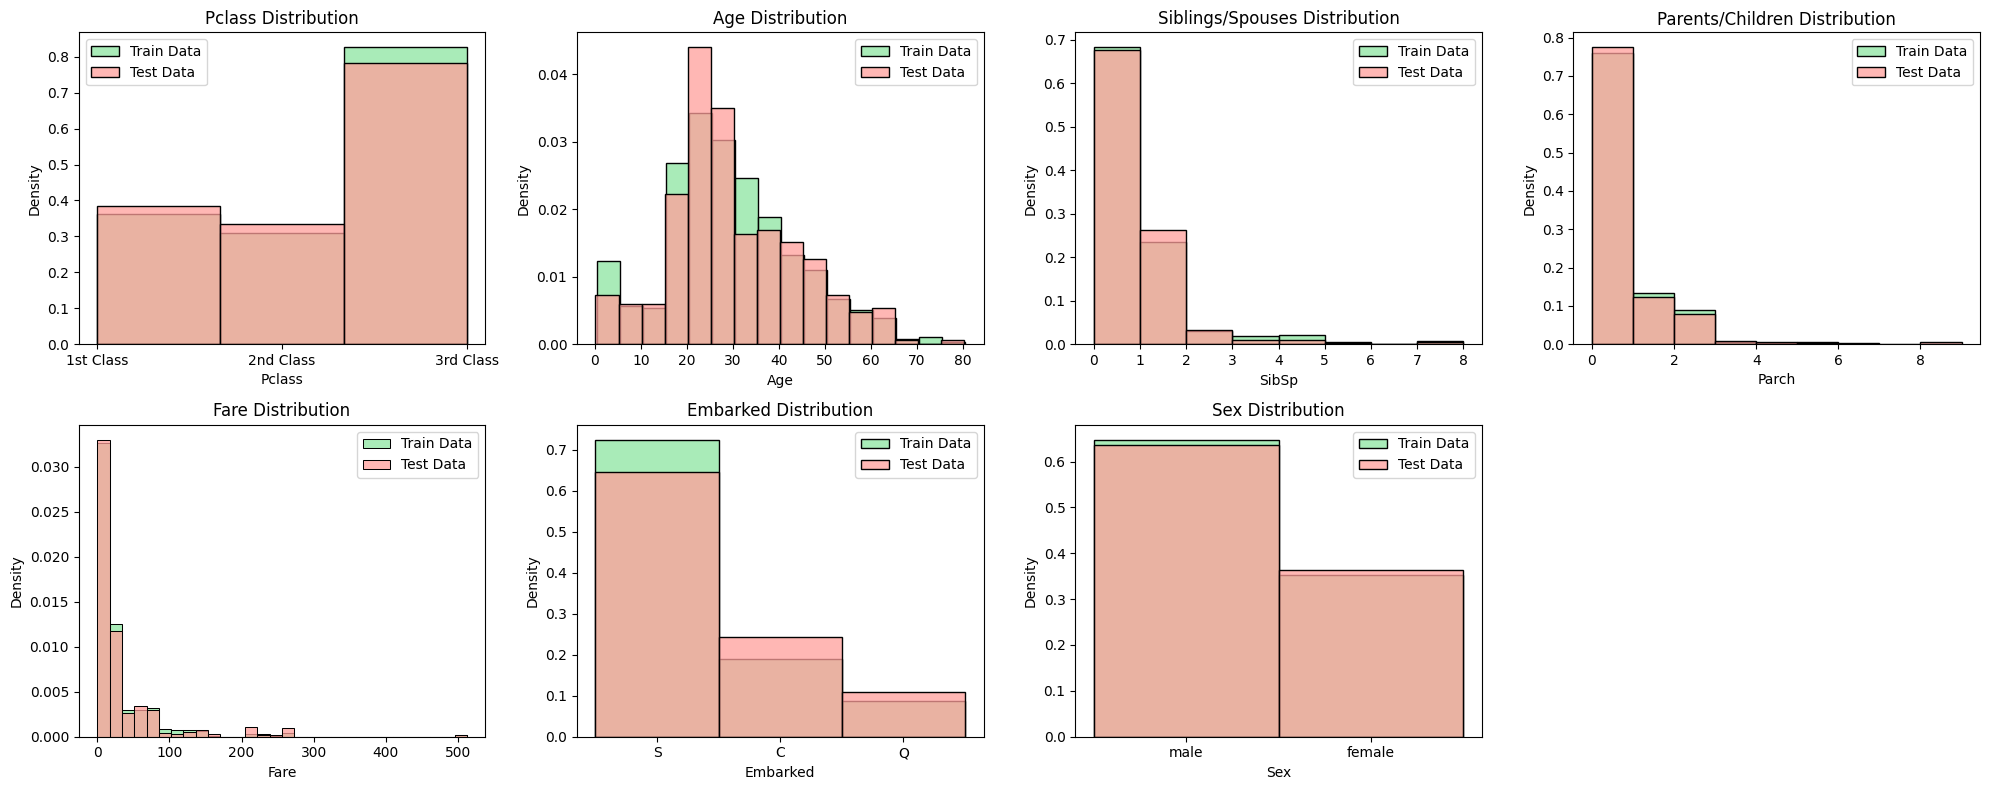

In [14]:
# Create subplots with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# Flatten the array of axes for easier iteration
axs = axs.flatten()

# Create the plots
sns.histplot(train_data["Pclass"], bins=3, color=color1, ax=axs[0], stat="density", label="Train Data")
sns.histplot(test_data["Pclass"], bins=3, color=color2, ax=axs[0], stat="density", label="Test Data")
axs[0].set_title('Pclass Distribution')
axs[0].set_xticks([1, 2, 3])
axs[0].set_xticklabels(['1st Class', '2nd Class', '3rd Class'])

sns.histplot(train_data["Age"],binwidth=5, color=color1, ax=axs[1], stat="density", label="Train Data")
sns.histplot(test_data["Age"],binwidth=5, color=color2, ax=axs[1], stat="density", label="Test Data")
axs[1].set_title('Age Distribution')

sns.histplot(train_data["SibSp"], binwidth=1, color=color1, ax=axs[2], stat="density", label="Train Data")
sns.histplot(test_data["SibSp"], binwidth=1, color=color2, ax=axs[2], stat="density", label="Test Data")
axs[2].set_title('Siblings/Spouses Distribution')

#sns.histplot(train_data["Parch"], bins=len(train_data["Parch"].unique()), color="#ff9f9b", ax=axs[3])
sns.histplot(train_data["Parch"], binwidth=1, color=color1, ax=axs[3], stat="density", label="Train Data")
sns.histplot(test_data["Parch"], binwidth=1, color=color2, ax=axs[3], stat="density", label="Test Data")
axs[3].set_title('Parents/Children Distribution')

sns.histplot(train_data["Fare"], bins=30, color=color1, ax=axs[4], stat="density", label="Train Data")
sns.histplot(test_data["Fare"], bins=30, color=color2, ax=axs[4], stat="density", label="Test Data")
axs[4].set_title('Fare Distribution')

sns.histplot(train_data["Embarked"], bins=3, color=color1, ax=axs[5], stat="density", label="Train Data")
sns.histplot(test_data["Embarked"], bins=3, color=color2, ax=axs[5], stat="density", label="Test Data")
axs[5].set_title('Embarked Distribution')

sns.histplot(train_data["Sex"], bins=2, color=color1, ax=axs[6], stat="density", label="Train Data")
sns.histplot(test_data["Sex"], bins=2, color=color2, ax=axs[6], stat="density", label="Test Data")
axs[6].set_title('Sex Distribution')

for i in range(7):
    axs[i].legend()

# Remove any empty subplots if n_vars < nrows * ncols
fig.delaxes(axs[7])

# Adjust layout to prevent overlap, add 
plt.tight_layout()

# Show the plots
plt.show()


### Short summary:

On test vs train data sample:

    * All distributions for test and train remain the same character except Age. In Test Data there is significantly less babies, teenagers and ~35-year old people, but more 20-30 years old people. This might be biased by missing values, so it is left to be verified after missing values handling. 

On variables distribution:

    * The people within low socio-economic status (pclass=3) are the majority on Titanic
    * As a consequence, the lowest fare tickets are the most frequent one.
    * The middle age group is the highest (20-40 years). There are significant number of babies (<5) and children overall <15)
    * There are signigicantly more males than females on the board
    * A lot of people travel alone. There are minority of large families on the board.
    * Most of passengers are embarked on Southampton.
    * SibSp, Parch and Fare have categorical variables that have a low frequency of occurrence and combining them into a single category might reduce the dimensionality of the data. Grouping rare categories is usefull for improving the robustness of the model by reducing the noise introduced by low frequency entries.
    * SibSp and Parch might be combined together to act as a Family Size feature.

Now let us have a look of average survival rate various categories within a feature.

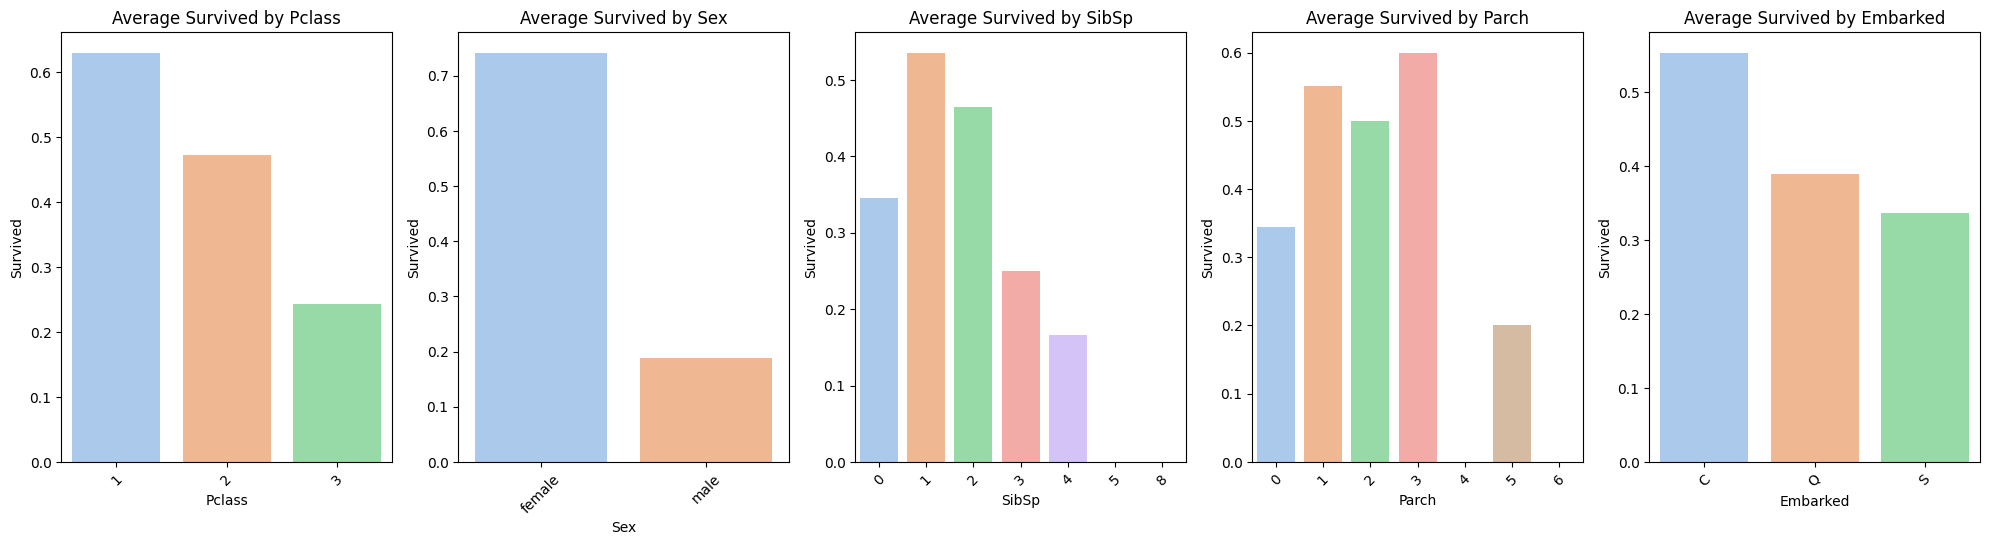

In [15]:
# Define the categorical variables
categorical_vars = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
plot_avg_survival(train_data, categorical_vars, "Survived")

### Short summary:

Reminder: average survival rate was 0.38. 

We can see significantly higher average Survival in category towards:

    * Pclas: 1st
    * Sex: Female
    * SibSp: 1-2 accompanying person
    * Embarked: C


We can see significantly lower average Survival in category towards:
   
    * Pclass: 3rd
    * Large families: SibSp: 4 and Parch: 5


Since 1st Pclass, females and C Embarked show higher survival, it is worth to check if this categories are related with each other. 

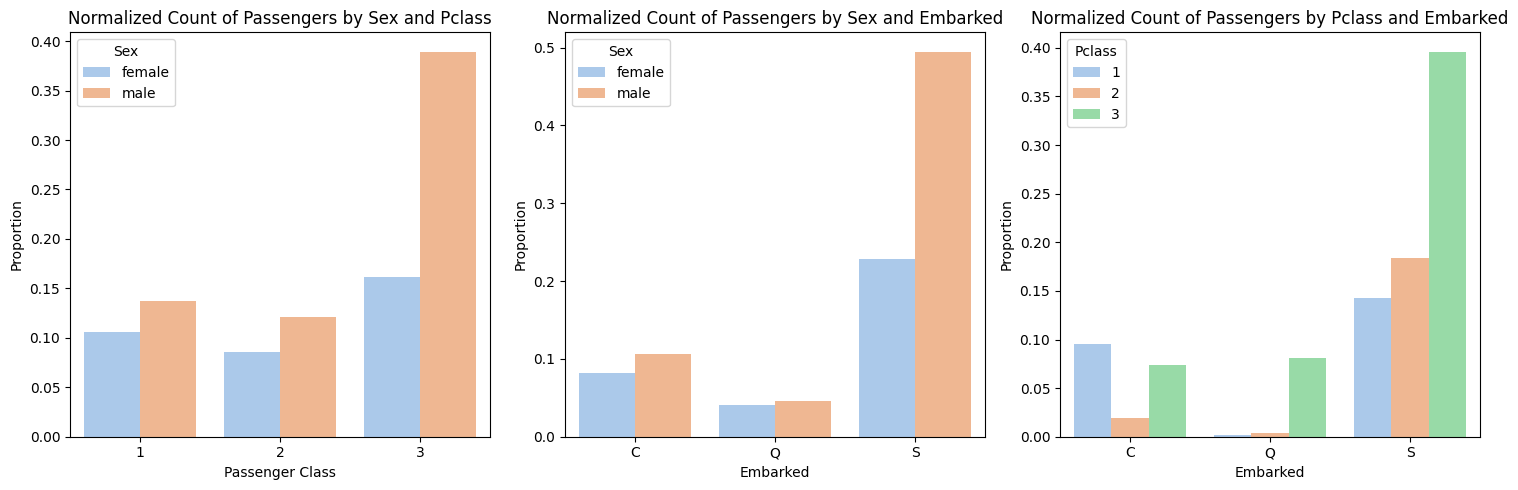

In [16]:
# Create subplots with 2 rows and 4 columns
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs = axs.flatten()

# Calculate the counts
counts = train_data.groupby(['Pclass', 'Sex']).size().reset_index(name='Count')
# Calculate the total number of passengers
total_passengers = len(train_data)
# Calculate the proportion
counts['Proportion'] = counts['Count'] / total_passengers

sns.barplot(x='Pclass', y='Proportion', hue='Sex', data=counts, ax=axs[0], palette='pastel')
axs[0].set_title('Normalized Count of Passengers by Sex and Pclass')
axs[0].set_xlabel('Passenger Class')
axs[0].set_ylabel('Proportion')

# -----------------------------------------

counts = train_data.groupby(['Embarked', 'Sex']).size().reset_index(name='Count')
counts['Proportion'] = counts['Count'] / total_passengers
sns.barplot(x='Embarked', y='Proportion', hue='Sex', data=counts, ax=axs[1], palette='pastel')
axs[1].set_title('Normalized Count of Passengers by Sex and Embarked')
axs[1].set_xlabel('Embarked')
axs[1].set_ylabel('Proportion')

# -----------------------------------------
counts = train_data.groupby(['Pclass', 'Embarked']).size().reset_index(name='Count')
counts['Proportion'] = counts['Count'] / total_passengers
sns.barplot(x='Embarked', y='Proportion', hue='Pclass', data=counts, ax=axs[2], palette='pastel')
axs[2].set_title('Normalized Count of Passengers by Pclass and Embarked')
axs[2].set_xlabel('Embarked')
axs[2].set_ylabel('Proportion')


plt.tight_layout()
plt.show()

### Short summary:

    * the majority of mans was traveling with 3rd class and was embarked in S -- this is shown on Survival rate
    * 2nd Pclass was Embarked mainly in S, but overall in S almost all passengers have been Embarked

Age and Fare are continous variables, thus one can look into boxplot and violin plots to find out details on variable distrubution over Survival = 0 and 1 groups.

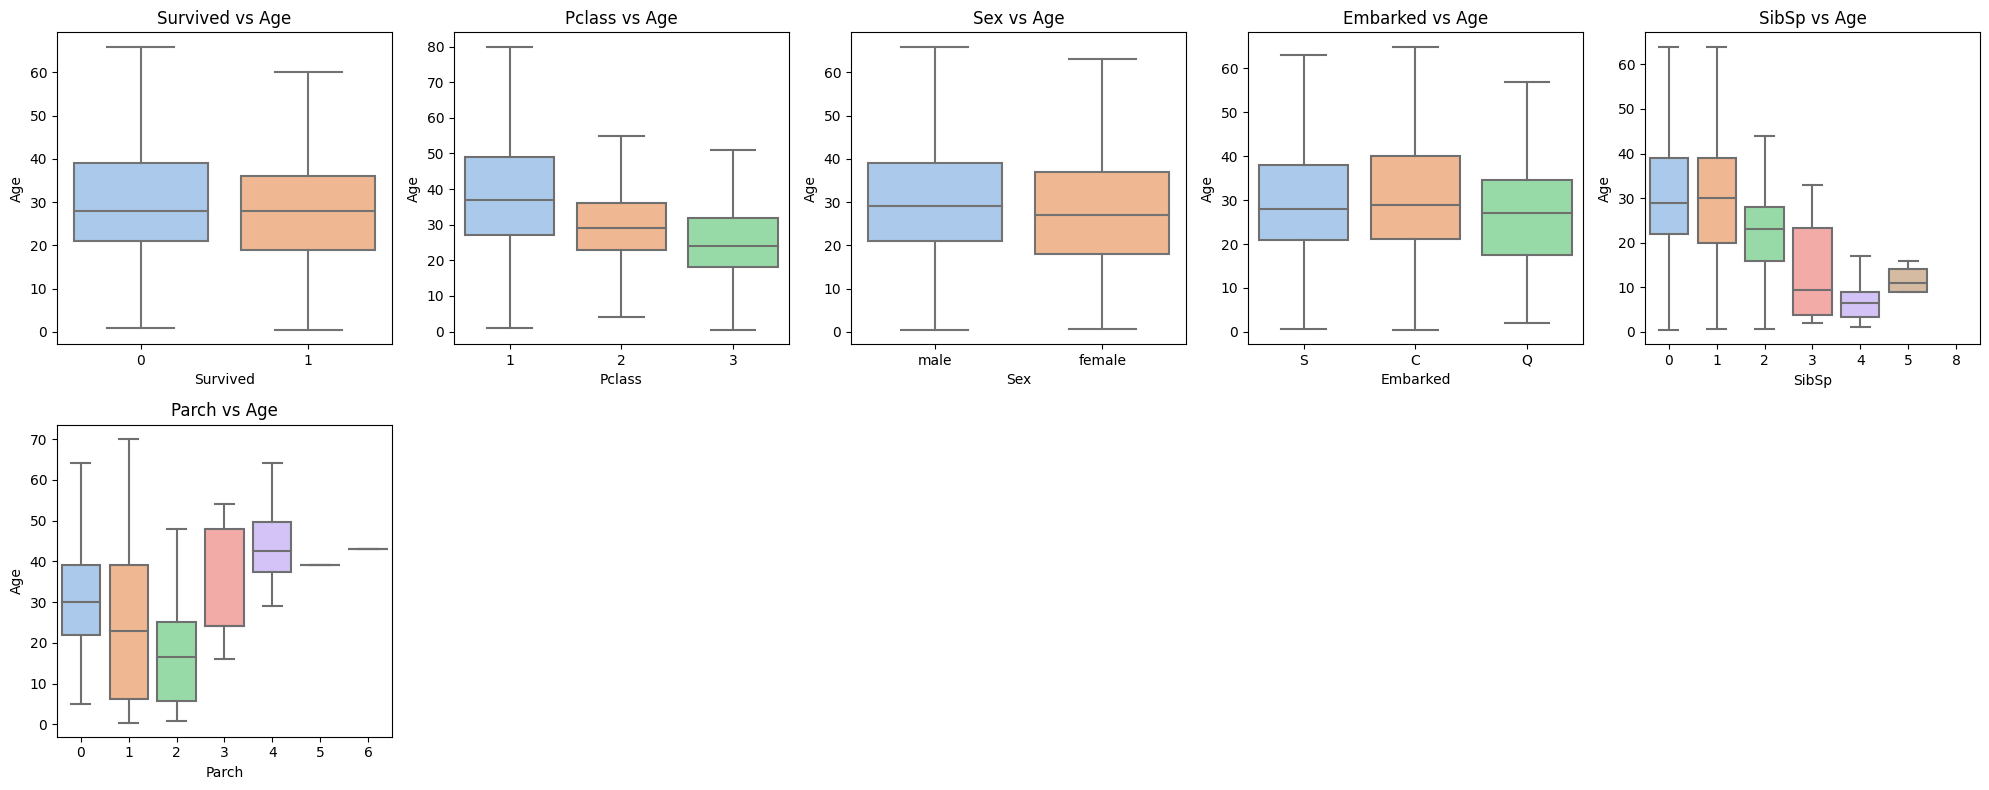

In [17]:
categories = ["Survived", "Pclass", "Sex", "Embarked", "SibSp", "Parch"]
yvar = 'Age'
plot_boxplots(categories, yvar, train_data)

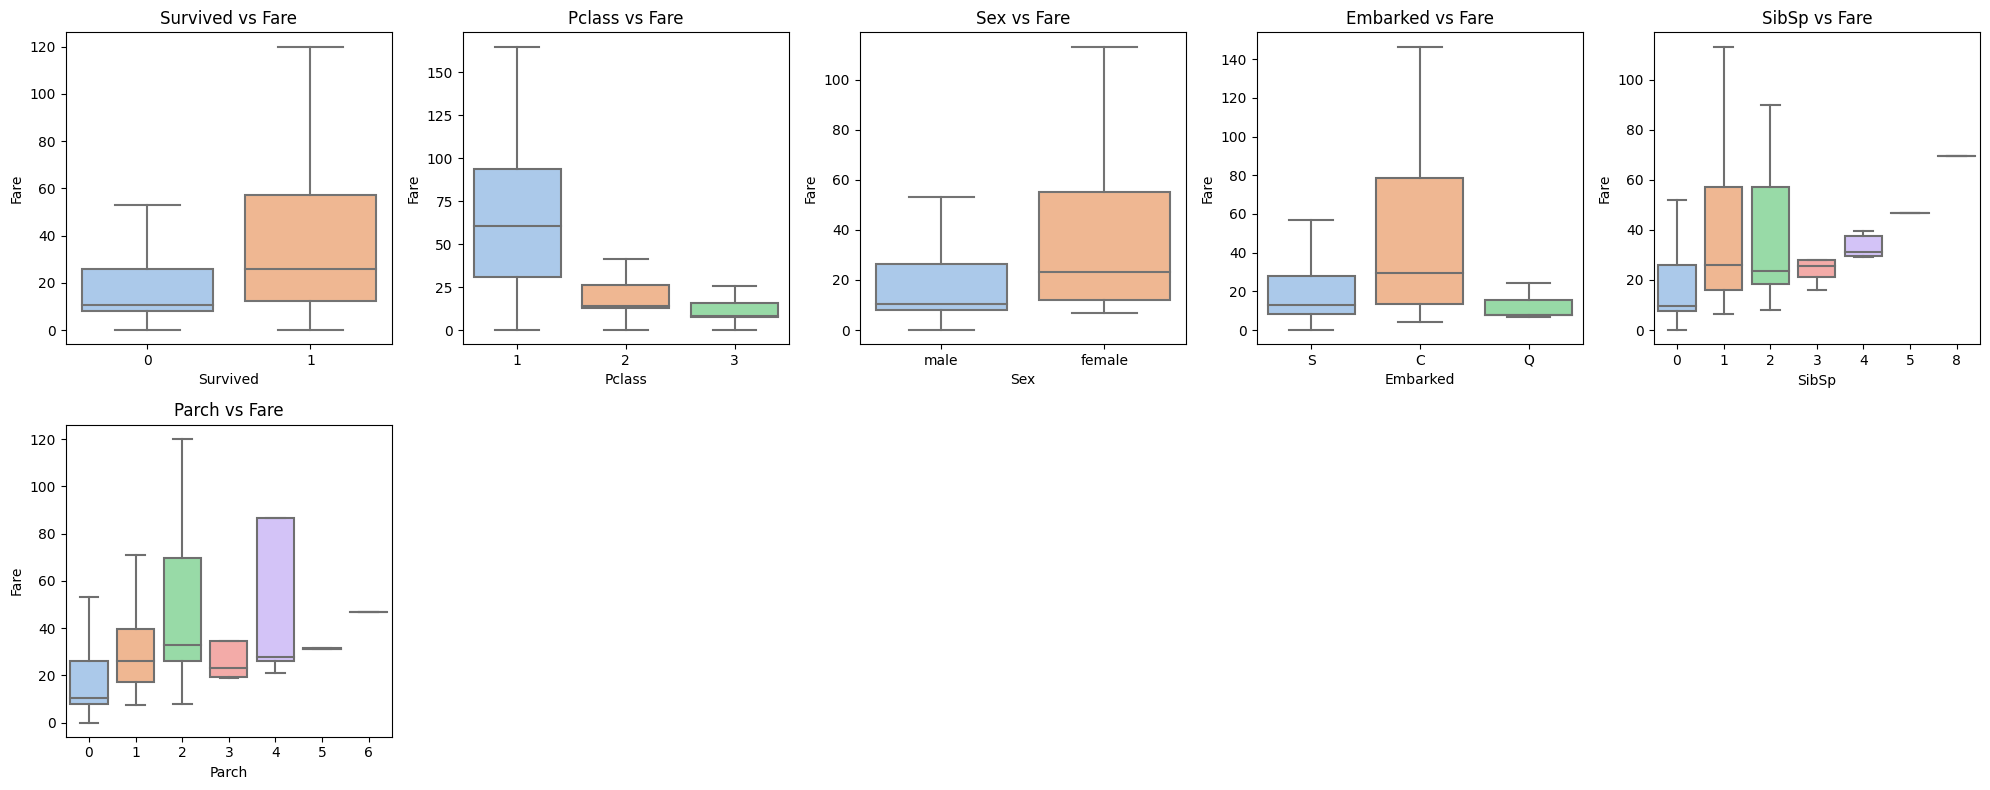

In [18]:
categories = ["Survived", "Pclass", "Sex", "Embarked", "SibSp", "Parch"]
yvar = 'Fare'
plot_boxplots(categories, yvar, train_data)

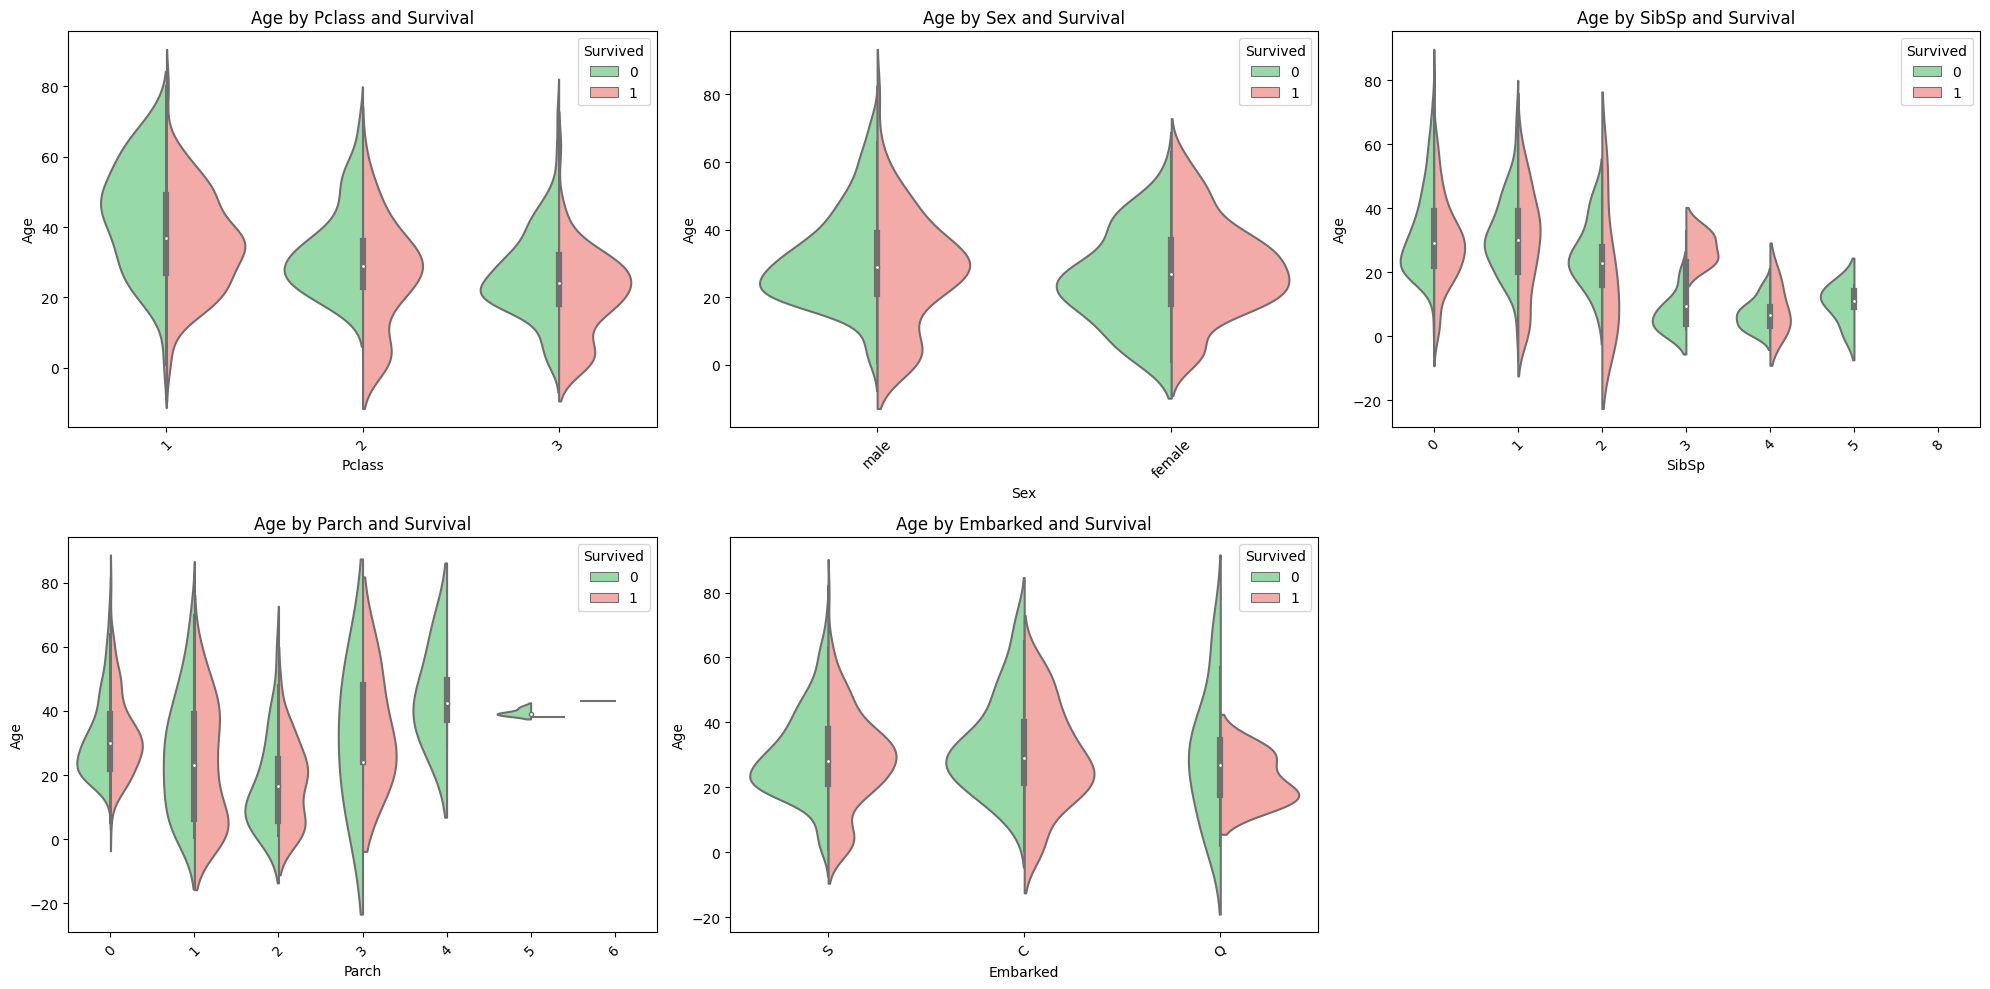

In [19]:
categorical_vars = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
plot_grouped_violin(train_data, categorical_vars, 'Age')


### Short summary:

    * Interesting Remark: People travelling with Spouse/Siblings (SibSp=3) survived when ~Age > 20 and not when Age < ~20. For this group the sharp division between Survived/Not Survived is observed.
    * In general younger girls have higher probability to survive. 

It is also usefull see specific features for categorical variables:

In [20]:
train_data.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Short summary:
    * Cabin and Ticket are not unique

# FEATURE ENGEENERING AND ENCODING


People travelling in small group have higher survival rate. The additional information that can be drained from Name, Ticket (not unique), and SibSb is if the passenger is travelling with her Spouse. Clarify conditions for couple:

       * Check if two passengers have the same ticket number and the same last name.
       * Ensure one is a woman and the other is a man.
       * One of the names should include "Mrs."
       * The SibSp (number of siblings/spouses aboard the Titanic) should be 1.
   
Introduce such a feature into data as isMarried. 

In [21]:
def isMarried(df):
    # Initialize the isMarried column with 0s
    df['isMarried'] = 0
    
    # Extract last names
    df['LastName'] = df['Name'].apply(lambda name: name.split(',')[0].strip())
    
    # Create a boolean column for "Mrs."
    df['IsMrs'] = df['Name'].apply(lambda name: 'Mrs.' in name)
    
    # Find potential couples based on the conditions
    couples = []
    for idx, row in df.iterrows():
        if row['IsMrs'] and row['SibSp'] == 1:
            # Find potential husbands
            potential_husbands = df[(df['Ticket'] == row['Ticket']) & 
                                    (df['LastName'] == row['LastName']) & 
                                    (df['Sex'] == 'male')]
            for _, husband in potential_husbands.iterrows():
                if husband['SibSp'] == 1:
                    df.loc[idx, 'isMarried'] = 1
                    df.loc[husband.name, 'isMarried'] = 1
                    couples.append((row['Name'], husband['Name']))
    
    return df, couples

In [22]:
# Apply the function to the dataframe
train_data, couples = isMarried(train_data)

# Print the dataframe to verify the new column
print(train_data[['Name', 'isMarried']])

# Print couples
print(f"Couples identified in train data {len(couples)}:")
for wife, husband in couples:
    print(f"Wife: {wife} - Husband: {husband}")

                                                  Name  isMarried
0                              Braund, Mr. Owen Harris          0
1    Cumings, Mrs. John Bradley (Florence Briggs Th...          0
2                               Heikkinen, Miss. Laina          0
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)          1
4                             Allen, Mr. William Henry          0
..                                                 ...        ...
886                              Montvila, Rev. Juozas          0
887                       Graham, Miss. Margaret Edith          0
888           Johnston, Miss. Catherine Helen "Carrie"          0
889                              Behr, Mr. Karl Howell          0
890                                Dooley, Mr. Patrick          0

[891 rows x 2 columns]
Couples identified in train data 45:
Wife: Futrelle, Mrs. Jacques Heath (Lily May Peel) - Husband: Futrelle, Mr. Jacques Heath
Wife: Nasser, Mrs. Nicholas (Adele Achem) - Husband: Nass

In [23]:
couples = []
test_data, couples = isMarried(test_data)
print(f"Couples identified in test data {len(couples)} ")


Couples identified in test data 13 


In [24]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
isMarried        int64
LastName        object
IsMrs             bool
dtype: object

The several actions would be performed on data:
1. **Sex** --> OneHotEncoding to keep independance between female and male features. Also Label Encoding for testing.
2. **Embarked** --> LabelEncoding
3. **Age** --> digitization and grouping rare categories
4. **Fare** --> digitization and grouping rare categories
5. **SibSp** + **Parch** --> adding a sum of them as a new feature FamilySize
6. **Ticket** --> Hashing encoding
7. **Cabin** --> extraction a desk and room number, see further description

In [25]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Braund,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Cumings,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Heikkinen,False


In [26]:
one_hot_encoded = pd.get_dummies(train_data['Sex'], prefix='Sex',  dtype=int)
train_data = train_data.join(one_hot_encoded)

one_hot_encoded = pd.get_dummies(test_data['Sex'], prefix='Sex',  dtype=int)
test_data = test_data.join(one_hot_encoded)

train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Braund,False,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Cumings,True,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Heikkinen,False,1,0


Now make one step faster than for other features, meaning fill up two missing values for Embarked with most frequent value and than encode using Label Encoding. This is done in such a way because only two missing values are observed for Embarked and this feautre seems to be not dominant in terms of relations to other features.

In [27]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Kelly,False,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,Wilkes,True,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Myles,False,0,1


In [28]:
datasets = [train_data, test_data]
most_frequent_embarked = train_data['Embarked'].mode()[0]

label_encoder = LabelEncoder()

for dataset in datasets:
    dataset['Embarked'] = dataset['Embarked'].fillna(most_frequent_embarked)
    dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
    dataset['Embarked'] = label_encoder.fit_transform(dataset['Embarked'])

#print("Mapping for 'Sex':")
#for i, label in enumerate(label_encoder.classes_):
#    print(f"{label}: {i}")

print("Mapping for 'Embarked':")
for i, label in enumerate(label_encoder.classes_):
   print(f"{label}: {i}")
    
train_data.head(5)

Mapping for 'Embarked':
C: 0
Q: 1
S: 2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,0,Braund,False,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0,Cumings,True,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0,Heikkinen,False,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2,1,Futrelle,True,1,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,2,0,Allen,False,0,1


In [29]:
# --- Transform Age to categorical values and apply Encoding
age_bins = [0, 10, 20, 30, 40, 50, 60, 100]  
age_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']  # Define age labels
label_encoder = LabelEncoder()

for dataset in datasets:
    dataset['Age_Cat'] = pd.cut(dataset['Age'], bins=age_bins, labels=age_labels)
    dataset['Age_Group'] = label_encoder.fit_transform(dataset['Age_Cat'])
    dataset["Age_Group"] = dataset["Age_Group"].replace(7, np.nan)

train_data.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,2,0,Braund,False,0,1,20-30,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0,0,Cumings,True,1,0,30-40,3.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0,Heikkinen,False,1,0,20-30,2.0


In [30]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,1,0,Kelly,False,0,1,30-40,3.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,2,0,Wilkes,True,1,0,40-50,4.0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,1,0,Myles,False,0,1,60+,6.0


In [31]:
# --- Transform Fare to categorical values and apply Encoding
fare_bins = [0, 50, 100, 150, 200, float('inf')]
fare_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

for dataset in datasets:
    dataset['Fare_Cat'] = pd.cut(dataset['Fare'], bins=fare_bins, labels=fare_labels)
    dataset['Fare_Group'] = label_encoder.fit_transform(dataset['Fare_Cat'])
    dataset["Fare_Group"] = dataset["Fare_Group"].replace(7, np.nan)

train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,2,0,Braund,False,0,1,20-30,2.0,Very Low,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,0,Cumings,True,1,0,30-40,3.0,Low,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,2,0,Heikkinen,False,1,0,20-30,2.0,Very Low,4


In [32]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,isMarried,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,1,0,Kelly,False,0,1,30-40,3.0,Very Low,4
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,2,0,Wilkes,True,1,0,40-50,4.0,Very Low,4
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,1,0,Myles,False,0,1,60+,6.0,Very Low,4


In [33]:
datasets = [train_data, test_data]

for dataset in datasets:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch']
    
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,isMarried,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,Braund,False,0,1,20-30,2.0,Very Low,4,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,Cumings,True,1,0,30-40,3.0,Low,1,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,0,Heikkinen,False,1,0,20-30,2.0,Very Low,4,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,1,Futrelle,True,1,0,30-40,3.0,Low,1,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,Allen,False,0,1,30-40,3.0,Very Low,4,0
5,6,0,3,"Moran, Mr. James",1,NaN,0,0,330877,8.4583,...,0,Moran,False,0,1,NaN,NaN,Very Low,4,0
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,...,0,McCarthy,False,0,1,50-60,5.0,Low,1,0
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,...,0,Palsson,False,0,1,0-10,0.0,Very Low,4,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,...,0,Johnson,True,1,0,20-30,2.0,Very Low,4,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,...,1,Nasser,True,1,0,10-20,1.0,Very Low,4,1


In [34]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,isMarried,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group,FamilySize
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,...,0,Kelly,False,0,1,30-40,3.0,Very Low,4,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,...,0,Wilkes,True,1,0,40-50,4.0,Very Low,4,1
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,...,0,Myles,False,0,1,60+,6.0,Very Low,4,0


In [35]:
#Hashing the Ticket feature
hash_space_size = 10000000

for dataset in datasets:
    dataset['Ticket_num'] = dataset['Ticket'].apply(lambda x: hash(x) % hash_space_size)

train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,LastName,IsMrs,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group,FamilySize,Ticket_num
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,Braund,False,0,1,20-30,2.0,Very Low,4,1,4926840
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,Cumings,True,1,0,30-40,3.0,Low,1,1,3914280
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,Heikkinen,False,1,0,20-30,2.0,Very Low,4,0,5923896


Check if hashing is done without overlay (Ticket and Ticket_num should be the same). For this the SQL command will be use since it is easy and straightforeward:

In [36]:
train_data.to_sql(name='sql_train', con=connection, if_exists='replace', index=False)

891

In [37]:
%%sql SELECT 
    (SELECT COUNT(DISTINCT Ticket) FROM sql_train) AS unique_tickets,
    (SELECT COUNT(DISTINCT Ticket_num) FROM sql_train) AS unique_ticked_encoded 
FROM sql_train
LIMIT 1

 * sqlite:///mydatabase.db
Done.


unique_tickets,unique_ticked_encoded
681,681


Cabin number is related to the passenger room and desk -- thus it can be related to the survival rate (correlation between passenger privilages/class and access to rescure boat or just a possible position of the passenger during the catastrophe). This two variables are more deeply investigated below:

Cabin value is a DECK+ROOM. Decks values are like follows:
* A: The Boat Deck (topmost deck), including cabins for some First-Class passengers.
* B: Promenade Deck, mostly First-Class cabins.
* C: Upper Deck, primarily First-Class cabins.
* D: Middle Deck, a mix of First-Class and Second-Class cabins.
* E: Lower Deck, primarily Second-Class cabins.
* F: Orlop Deck, crew quarters and some Third-Class cabins.
* G: Tank Top, mostly crew and Third-Class areas.

Cabin number seems to be not obvious to handle with since:
* there are a lot of missing values
* some entries contain more than one cabin number, which reason is non straightforeward. Important remark is if there is more than one cabin in the entry, the deck is the same and the room number is close by. This means that the valuable outcomes (deck and position of the room) can be extracted selecting one cabin number from several appearing in the entry. 

The proposed treatment of the Cabin number is to split the object into "Deck" and "Room" variables. Than, for sake of the deeper data understanding, one can have a look into correlation between Deck/Room and Fare and Pclass to see. If so, one can assume that missing Cabin numbers can be succesfully predicted in the next steps. Having this in mind, the encoding for Cabin will contain:
* spliting Cabin into Deck and Room features
* Label Encoding of Deck A, B, C, D, E, F into numbers, None to 0. Single "T" entry goes for 0 also, since it is not mentioned in decks categories mentioned above and could be anomaly. 
* Changing Room type to float.


In [38]:
#expand ensures that in the dataframe two news feature are created each containing one group from regular expression
# ([a-zA-Z]+) -- any letter in the first group or + more
# (\d+) -- any digit or more 

datasets = [train_data, test_data]

for dataset in datasets:
    dataset[['Desk', 'Room']] = dataset['Cabin'].str.extract(r'([a-zA-Z]+)(\d+)', expand=True)
    dataset['Desk'] = label_encoder.fit_transform(dataset['Desk'])
    dataset["Desk"] = dataset["Desk"].replace(7, np.nan).astype(float)
    dataset["Room"] = dataset["Room"].astype(float)
    
print("Mapping for 'Desk':")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")   

train_data.head(5)

Mapping for 'Desk':
A: 0
B: 1
C: 2
D: 3
E: 4
F: 5
G: 6
nan: 7


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group,FamilySize,Ticket_num,Desk,Room
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,1,20-30,2.0,Very Low,4,1,4926840,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,1,0,30-40,3.0,Low,1,1,3914280,2.0,85.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,20-30,2.0,Very Low,4,0,5923896,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,1,0,30-40,3.0,Low,1,1,767555,2.0,123.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,1,30-40,3.0,Very Low,4,0,7273275,NaN,NaN


In [39]:
test_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Sex_female,Sex_male,Age_Cat,Age_Group,Fare_Cat,Fare_Group,FamilySize,Ticket_num,Desk,Room
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,...,0,1,30-40,3.0,Very Low,4,0,2698101,NaN,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,...,1,0,40-50,4.0,Very Low,4,1,6393362,NaN,NaN
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,...,0,1,60+,6.0,Very Low,4,0,394377,NaN,NaN


In [40]:
%sql SELECT COUNT(DISTINCT Sex) AS unique_Sex, COUNT(DISTINCT Ticket) AS unique_Ticket, COUNT(DISTINCT Desk) AS unique_Desk, COUNT(DISTINCT Embarked) AS unique_Embarked, COUNT(DISTINCT Room) AS unique_Room FROM sql_train

 * sqlite:///mydatabase.db
(sqlite3.OperationalError) no such column: Desk
[SQL: SELECT COUNT(DISTINCT Sex) AS unique_Sex, COUNT(DISTINCT Ticket) AS unique_Ticket, COUNT(DISTINCT Desk) AS unique_Desk, COUNT(DISTINCT Embarked) AS unique_Embarked, COUNT(DISTINCT Room) AS unique_Room FROM sql_train]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


Let us have a look into descriptive plots now:

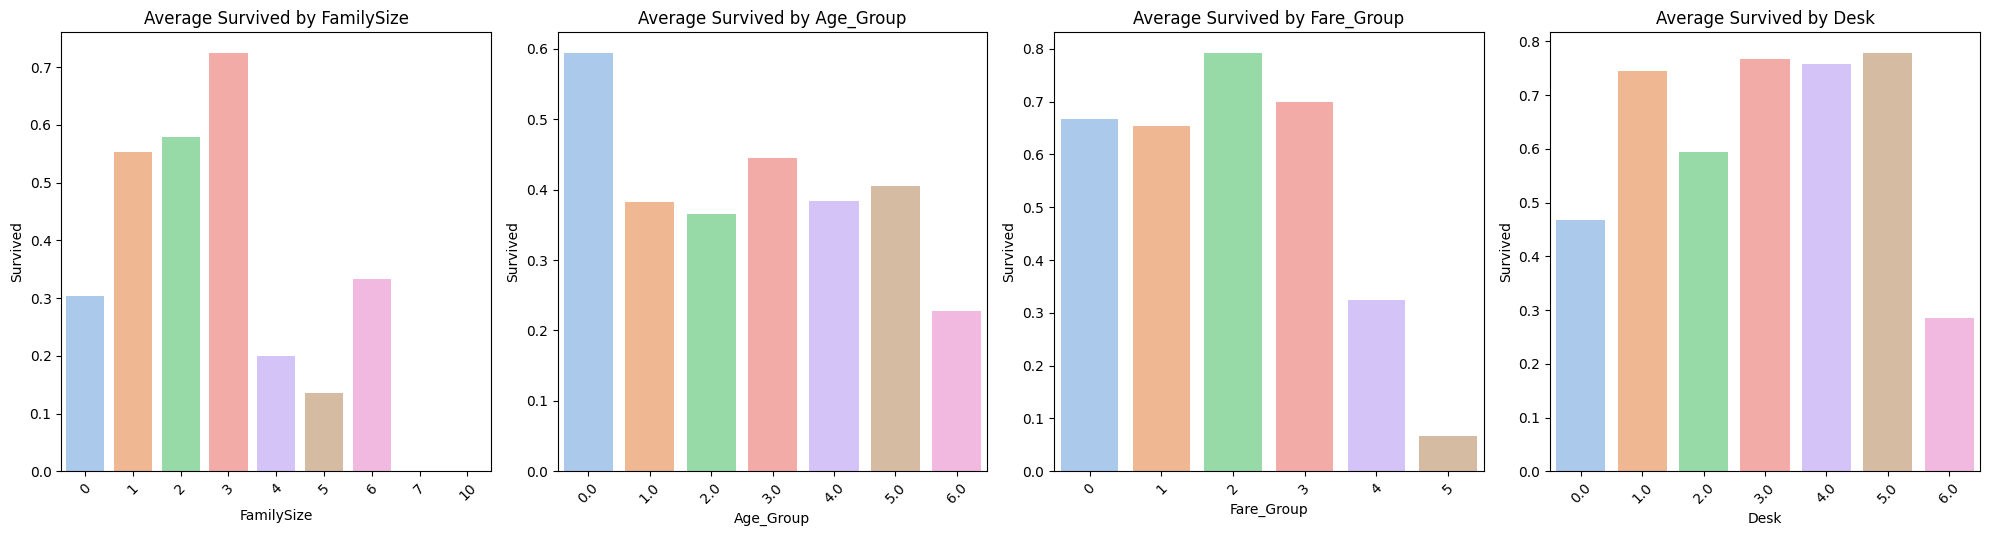

In [41]:
categorical_vars = ['FamilySize', 'Age_Group', 'Fare_Group', 'Desk']
plot_avg_survival(train_data, categorical_vars, "Survived")

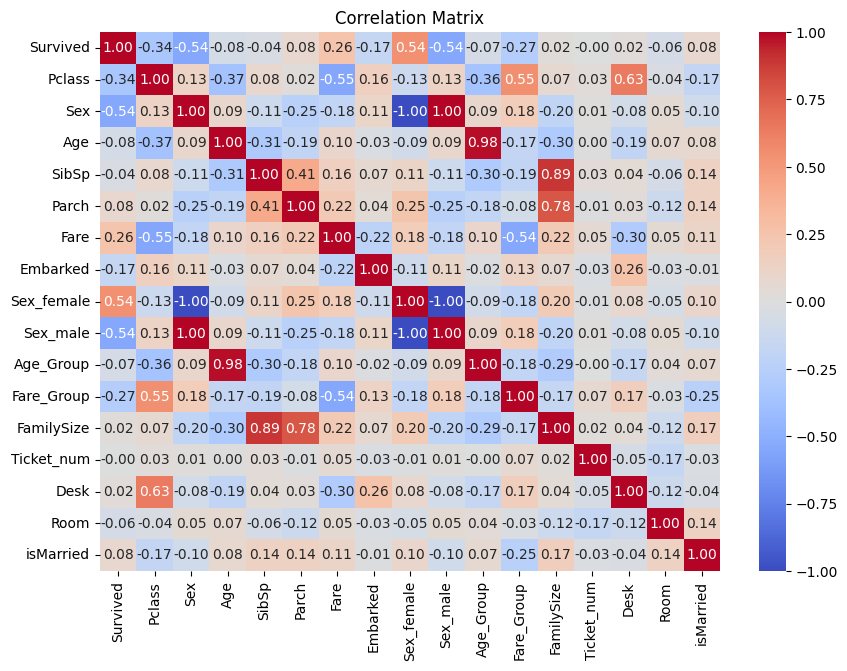

In [42]:
train_data_cut = pd.DataFrame(train_data,
    columns=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
             'Embarked', 'Sex_female', 'Sex_male', 'Age_Group', 'Fare_Group', 
             'FamilySize', 'Ticket_num', 'Desk', 'Room', 'isMarried']
)

correlation = train_data_cut.corr()
plot_corr(correlation)

In [43]:
train_data.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex               int64
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked          int64
isMarried         int64
LastName         object
IsMrs              bool
Sex_female        int64
Sex_male          int64
Age_Cat        category
Age_Group       float64
Fare_Cat       category
Fare_Group        int64
FamilySize        int64
Ticket_num        int64
Desk            float64
Room            float64
dtype: object

In [44]:
#test_data.dtypes

Encoding is done. Drop the object values that would not be usefull in further analysis. Afterwards, it is worth to look into correlation plot to see first relations between variables. 

In [45]:
train_data = train_data.drop( columns=['Name','Ticket','Cabin','Age_Cat','Fare_Cat', 'IsMrs','LastName'])
test_data = test_data.drop( columns=['Name','Ticket','Cabin','Age_Cat','Fare_Cat', 'IsMrs','LastName'])

train_data.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk,Room
0,1,0,3,1,22.0,1,0,7.2500,2,0,0,1,2.0,4,1,4926840,NaN,NaN
1,2,1,1,0,38.0,1,0,71.2833,0,0,1,0,3.0,1,1,3914280,2.0,85.0
2,3,1,3,0,26.0,0,0,7.9250,2,0,1,0,2.0,4,0,5923896,NaN,NaN


In [46]:
test_data.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk,Room
0,892,3,1,34.5,0,0,7.8292,1,0,0,1,3.0,4,0,2698101,NaN,NaN
1,893,3,0,47.0,1,0,7.0000,2,0,1,0,4.0,4,1,6393362,NaN,NaN
2,894,2,1,62.0,0,0,9.6875,1,0,0,1,6.0,4,0,394377,NaN,NaN


## Missing values handling

Among test or train datasets, there are missing/NaN values for Age, Cabin, Fare and Embarked variables. The following approach will be applied to particular variables: 
* **Age** - age might have a large impact on Survival Rate. Replacing missing values by age would be way more not accurate. Since there are other features that might be correlated with age (family members for example), it is better to apply model to predict age.
  The extended imputation will be done in both cases, keeping additional information about Age data source (if predicted or source data). 
* **Fare** - replaced by average fare of the same Pclass group.  
* **Deck**, **Room** - similar situation as with the Age, predictive analysis would be applied.


In [47]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
isMarried        0
Sex_female       0
Sex_male         0
Age_Group      177
Fare_Group       0
FamilySize       0
Ticket_num       0
Desk           691
Room           691
dtype: int64

In [48]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             1
Embarked         0
isMarried        0
Sex_female       0
Sex_male         0
Age_Group       86
Fare_Group       0
FamilySize       0
Ticket_num       0
Desk           329
Room           329
dtype: int64

In general, the number of missing values for feature Cabin and Deck/Room should be the same which is not the point. One can assume, that there were some values stored in Cabin column, that applied regular expression did not handle correctly (like for passengers ID 293 or 340). Since there are only 4 entries like this, let's leave it like this. Anyway, crosscheck if the issue is understood:

In [49]:
unnormal_cabin = [293,340]
row = train_data[train_data['PassengerId'].isin(unnormal_cabin)]
row

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk,Room
292,293,0,2,1,36.0,0,0,12.875,0,0,0,1,3.0,4,0,3332294,NaN,NaN
339,340,0,1,1,45.0,0,0,35.500,2,0,0,1,4.0,4,0,705645,NaN,NaN


### Handle missing values for Fare

For the fare, replace the missing_value with the average fare value for particular Pclass.

In [50]:
datasets=[train_data, test_data]
# Calculate the average fare for each Pclass
average_fare_by_pclass = train_data.groupby('Pclass')['Fare'].mean()

# Define a function to fill NaN values with the average fare for their Pclass
def fill_na_with_avg_fare(row):
    if pd.isnull(row['Fare']):
        return average_fare_by_pclass[row['Pclass']]
    else:
        return row['Fare']
    
# Apply the function to fill NaN values in the 'Fare' column
for dataset in datasets:
    dataset['Fare'] = dataset.apply(fill_na_with_avg_fare, axis=1)

test_data['Fare'].isnull().sum()

0

### Handle missing values for Age, Desk and Room

Here are functions that would be usefull in further analysis:

In [51]:
def evaluate_classifiers(classifiers, param_grids, X_train, y_train, X_test, y_test):
    best_score = 0
    best_score_CV = 0
    best_score_temp = 0
    best_model = None
    score_train = []
    score_test = []

    for name, model in classifiers.items():
        print(f"Evaluating {name}...")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train, y_train)

        #print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
        train_score = grid_search.score(X_train, y_train)
        print(f"Train score: {train_score:.4f}")
        test_score = grid_search.score(X_test, y_test)
        print(f"Test score: {test_score:.4f}")
        score_train.append(train_score)
        score_test.append(test_score)
        best_score_temp = test_score
        y_pred=grid_search.predict(X_test)
        print("\n")

        # Check if the current model has the best score
        #if grid_search.best_score_ > best_score:
        if best_score_temp > best_score:
            best_model = grid_search.best_estimator_
            best_score_CV = grid_search.best_score_
            best_score = best_score_temp
            acc = round(accuracy_score(y_pred, y_test), 3)

    print(f"The best model estimator: {best_model} with score on test data: {best_score:.4f} and best cross-validation socre {best_score_CV:.4f}")
    print(f"Accuracy score: {acc:.3f}")

    return score_train, score_test, best_model, best_score

In [52]:
def plot_models_comparision(df):
    # Create a bar plot
    sns.barplot(data=df, x='models', y='score_train', color=color1,  alpha=0.5, label='Best CV Score')
    sns.barplot(data=df, x='models', y='score_test',  color=color2, alpha=0.5, label='Test Score')

    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Accuracy of Different Models')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()  # Show legend

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

### Predicting Age missing values

In general, Age is a continuos feature, but having features such as in TitanicData set, it would be difficult to predict exact Age values. It was on Ridge and Lasso linear regression models, giving the best R^2 score of 0.25. Since it makes sens to consider average survival among Age group, further in the analysis Age will be discarded and Age_Group will be kept in analysis. Age_Group is correlated with Family size indicators, Pclass, Ticket and Fare. Let us build several sets of features and test which model behaves the best and what are its metrics.

|                                            	| Best Model 	| Best Score CV 	| Best Score Test 	|
|:------------------------------------------:	|:----------:	|:-------------:	|:---------------:	|
| Pclass                                     	|LogisticRegression|0.2797|0.2797|
| Pclass, SibSp                              	|RandomForestClassifier|0.3427|0.3449|
| Pclass, Parch                              	|DecisionTreeClassifier|0.3566|0.3924|
| Pclass, FamilySize                         	|KNeighborsClassifier|0.3357|                 0.3328|
| Pclass, Ticket_Num                         	|SVC|0.2937|                 0.3292|
| Pclass, Fare_Group                         	|RandomForestClassifier|0.2937|0.3258|
| **Pclass, Parch, Fare_Group**             	|**DecisionTreeClassifier**|**0.3566**|**0.3959**|
| Pclass, Parch, Ticket_Num             	|DecisionTreeClassifier|0.3566|0.3784|
| Pclass, Parch, Ticket_Num, Fare_Group 	|DecisionTreeClassifier|0.3566|0.3748|
| All 	|DecisionTreeClassifier|0.3566|0.3508|

It was verified, but not shown here for clarity: 
* Parch working alone is the best indicator for Age prediction among family size information. Thus, this feature is used further.

In [53]:
# Prepare target and features
X_features = ['Pclass', 'Parch', 'Fare_Group']

train_data_age = train_data.dropna(subset=['Age_Group'])

#X = train_data_age.drop(['Age_Group', 'Age', 'PassengerId', 'Room', 'Survived','Desk'], axis=1)  # Features
X = pd.DataFrame(train_data_age, columns=X_features) # Features
y = train_data_age['Age_Group']  # Target variable

# Split into training and test data sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

X.head(5)

,Pclass,Parch,Fare_Group
0,3,0,4
1,1,0,1
2,3,0,4
3,1,0,1
4,3,0,4


In [54]:
# Define classifieriers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 5, 10], 'penalty':['l1','l2'],'solver':['liblinear']}, 
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 3, 5, 6]},  
    'Random Forest': {'n_estimators': [10, 20, 30], 'max_features': ['sqrt', 'log2']},  
    'SVM': {'C': [0.01, 0.05, 1], 'kernel': ['poly','sigmoid', 'rbf']}, 
    'KNN': {'n_neighbors': [2, 3, 5]},  
    'Naive Bayes': {} 
}

best_model = None
best_score = 0
score_train = [] 
score_test = [] 

score_train, score_test, best_model, best_score = evaluate_classifiers(classifiers, param_grids, X_train, y_train, X_test, y_test)

Evaluating Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best cross-validation score: 0.3450
Train score: 0.3538
Test score: 0.3357


Evaluating Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best cross-validation score: 0.3959
Train score: 0.4343
Test score: 0.3566


Evaluating Random Forest...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best cross-validation score: 0.3889
Train score: 0.4361
Test score: 0.3566


Evaluating SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best cross-validation score: 0.3959
Train score: 0.4063
Test score: 0.3427


Evaluating KNN...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best cross-validation score: 0.3555
Train score: 0.3835
Test score: 0.2797


Evaluating Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.3240
Train score: 0.3327
Test score: 0.3287


The best model estimator: 

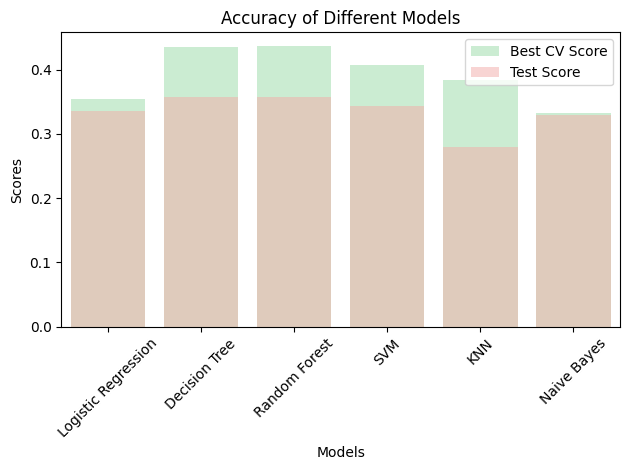

In [55]:
df = pd.DataFrame({'models': list(param_grids.keys()), 'score_train': score_train, 'score_test': score_test})
plot_models_comparision(df)

In [56]:
#Replace missing values in main data frames
datasets = [train_data, test_data]

for dataset in datasets:
    missing_age_indices = dataset[dataset['Age_Group'].isnull()].index
    if not missing_age_indices.empty:
        predicted_ages = best_model.predict(dataset.loc[missing_age_indices, X_features])
        dataset.loc[missing_age_indices, 'Age_Group'] = predicted_ages

        
print(f"Missing values in Age_Group category in train data: {train_data['Age_Group'].isnull().sum()} and in test data: {test_data['Age_Group'].isnull().sum()}")
train_data = train_data.drop(columns=['Age_Cat', 'Age'], axis=1, errors='ignore')
test_data  = test_data.drop(columns=['Age_Cat', 'Age'], axis=1, errors='ignore')

train_data.head(3)


Missing values in Age_Group category in train data: 0 and in test data: 0


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk,Room
0,1,0,3,1,1,0,7.2500,2,0,0,1,2.0,4,1,4926840,NaN,NaN
1,2,1,1,0,1,0,71.2833,0,0,1,0,3.0,1,1,3914280,2.0,85.0
2,3,1,3,0,0,0,7.9250,2,0,1,0,2.0,4,0,5923896,NaN,NaN


In [57]:
test_data.head(2)

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk,Room
0,892,3,1,0,0,7.8292,1,0,0,1,3.0,4,0,2698101,NaN,NaN
1,893,3,0,1,0,7.0000,2,0,1,0,4.0,4,1,6393362,NaN,NaN


In [58]:
#For me:

#train_data['Age'].isnull() creates a boolean mask where each element is True if the corresponding value in the 'Age' column is null and False otherwise.
#.index returns the index labels of the DataFrame where the boolean mask is True, effectively selecting the rows where the 'Age' column is null.
#So, missing_age_indices is a list of index labels corresponding to the rows in train_data where the 'Age' column has missing values.

### Predicting Desk missing values

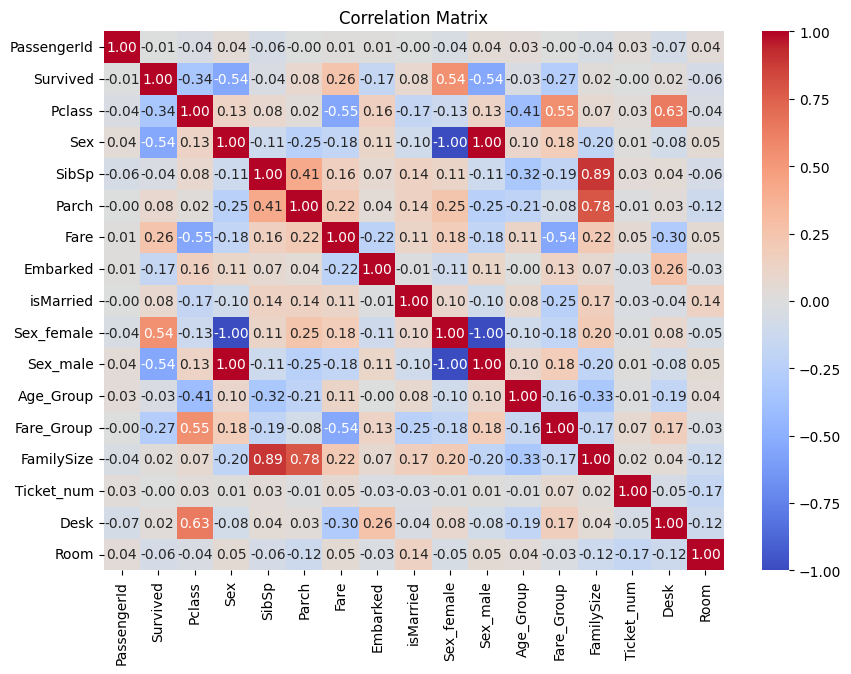

In [59]:
correlation_matrix = train_data.corr()
plot_corr(correlation_matrix)

Once again have a look into correlation plots. Room is not correlated with any other feature, since it will be discarded. Desk feature otherwise is related to Pclass, Fare (remark: more than Fare_Group!) and Embarked. One may also test Age_Group. Let us do this step as for Age_Group.

|                                            	| Best Model 	| Best Score CV 	| Best Score Test 	|
|:------------------------------------------:	|:----------:	|:-------------:	|:---------------:	|
| Pclass                                     	| LogisticRegression |0.3750|0.3500|
| **Pclass, Fare**                              	| DecisionTreeClassifier | 0.6250 |0.6150 |
| Pclass, Fare_Group                          	| LogisticRegression |0.3250|0.3562|
| Pclass, Embarked                             	| KNeighborsClassifier |0.3500|0.3250|
| Pclass, Age_Group                            	| LogisticRegression |0.3750 |0.3438|
| Pclass, Fare, Embarked                       	| RandomForestClassifier|0.6250|0.6062|
| Pclass, Fare, Embarked, Age_Group             	|DecisionTreeClassifier |0.5250|0.5000|


It was verified, but not shown here for clarity: 
* Indeed, the continuous variable Fare gives better predictions.
* For Desk prediction DecisionTreeClassifier() with score on test data: 0.6250 and best cross-validation socre 0.6125 is selected.

In [60]:
train_data = train_data.drop(columns=['Room'], axis=1, errors='ignore')
test_data  = test_data.drop(columns=['Room'], axis=1, errors='ignore')

In [61]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
# Fit the scaler on the 'Fare' column and transform it
#train_data['Fare'] = scaler.fit_transform(train_data[['Fare']])
#test_data['Fare'] = scaler.transform(test_data[['Fare']])

In [62]:
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 5, 10], 'penalty':['l1','l2'],'solver':['liblinear']}, 
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 3, 5]},  
    'Random Forest': {'n_estimators': [10, 20, 30,35], 'max_features': ['sqrt', 'log2']},  
    'SVM': {'C': [0.01, 0.05, 1], 'kernel': ['poly','sigmoid', 'rbf']}, 
    'KNN': {'n_neighbors': [2, 3, 5]},  
    'Naive Bayes': {} 
}

In [63]:
X_features = ['Pclass','Fare']

# Prepare target and features
train_data_desk = train_data.dropna(subset=['Desk'])
X = pd.DataFrame(train_data_desk, columns=X_features) # Features
y = train_data_desk['Desk']  # Target variable

# Split into training and test data sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
X.head(3)

,Pclass,Fare
1,1,71.2833
3,1,53.1000
6,1,51.8625


In [64]:
score_train, score_test, best_model, best_score = evaluate_classifiers(classifiers, param_grids, X_train, y_train, X_test, y_test)

Evaluating Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best cross-validation score: 0.3438
Train score: 0.3563
Test score: 0.4000


Evaluating Decision Tree...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best cross-validation score: 0.6125
Train score: 0.8938
Test score: 0.6250


Evaluating Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best cross-validation score: 0.6125
Train score: 0.8938
Test score: 0.6000


Evaluating SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best cross-validation score: 0.3125
Train score: 0.3125
Test score: 0.2750


Evaluating KNN...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best cross-validation score: 0.5375
Train score: 0.7812
Test score: 0.5500


Evaluating Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.3000
Train score: 0.3187
Test score: 0.3000


The best model estimator: D

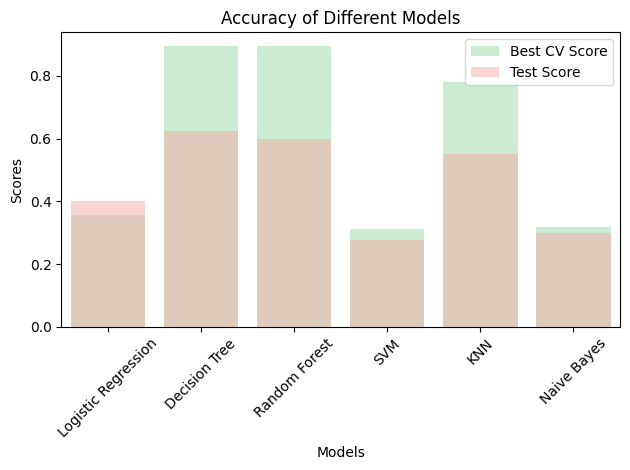

In [65]:
df = pd.DataFrame({'models': list(param_grids.keys()), 'score_train': score_train, 'score_test': score_test})
plot_models_comparision(df)

In [66]:
train_data.head(10)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk
0,1,0,3,1,1,0,7.2500,2,0,0,1,2.0,4,1,4926840,NaN
1,2,1,1,0,1,0,71.2833,0,0,1,0,3.0,1,1,3914280,2.0
2,3,1,3,0,0,0,7.9250,2,0,1,0,2.0,4,0,5923896,NaN
3,4,1,1,0,1,0,53.1000,2,1,1,0,3.0,1,1,767555,2.0
4,5,0,3,1,0,0,8.0500,2,0,0,1,3.0,4,0,7273275,NaN
5,6,0,3,1,0,0,8.4583,1,0,0,1,2.0,4,0,7011946,NaN
6,7,0,1,1,0,0,51.8625,2,0,0,1,5.0,1,0,2613059,4.0
7,8,0,3,1,3,1,21.0750,2,0,0,1,0.0,4,4,1312118,NaN
8,9,1,3,0,0,2,11.1333,2,0,1,0,2.0,4,2,8035388,NaN
9,10,1,2,0,1,0,30.0708,0,1,1,0,1.0,4,1,2439456,NaN


In [67]:
datasets = [train_data, test_data]
for dataset in datasets:
    missing_desk_indices = dataset[dataset['Desk'].isnull()].index
    if not missing_desk_indices.empty:
        predicted_desk = best_model.predict(dataset.loc[missing_desk_indices, X_features])
        dataset.loc[missing_desk_indices, 'Desk'] = predicted_desk
        
print(f"Missing values in Age_Group category in train data: {train_data['Age_Group'].isnull().sum()} and in test data: {test_data['Age_Group'].isnull().sum()}")

train_data.head(5)

Missing values in Age_Group category in train data: 0 and in test data: 0


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk
0,1,0,3,1,1,0,7.2500,2,0,0,1,2.0,4,1,4926840,6.0
1,2,1,1,0,1,0,71.2833,0,0,1,0,3.0,1,1,3914280,2.0
2,3,1,3,0,0,0,7.9250,2,0,1,0,2.0,4,0,5923896,5.0
3,4,1,1,0,1,0,53.1000,2,1,1,0,3.0,1,1,767555,2.0
4,5,0,3,1,0,0,8.0500,2,0,0,1,3.0,4,0,7273275,5.0


In [68]:
train_data.head(5)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,isMarried,Sex_female,Sex_male,Age_Group,Fare_Group,FamilySize,Ticket_num,Desk
0,1,0,3,1,1,0,7.2500,2,0,0,1,2.0,4,1,4926840,6.0
1,2,1,1,0,1,0,71.2833,0,0,1,0,3.0,1,1,3914280,2.0
2,3,1,3,0,0,0,7.9250,2,0,1,0,2.0,4,0,5923896,5.0
3,4,1,1,0,1,0,53.1000,2,1,1,0,3.0,1,1,767555,2.0
4,5,0,3,1,0,0,8.0500,2,0,0,1,3.0,4,0,7273275,5.0


# PREDICTING SURVIVAL RATE

For model predicing several models are tested and tuning hyperparameters for each of them is done. Cross-validation with 5 folds is done for each.  Cross-validation is a technique used to evaluate how well a model will generalize to an independent dataset. It involves partitioning the dataset into subsets, training the model on some subsets, and evaluating it on the remaining subsets.

Here is a short descriprion of used models:

1. **Logistic Regression:** A linear model used for binary classification. It models the probability that a given input belongs to a certain class.

2. **Decision Tree:** A tree-like model where an input is split into branches based on certain features. It's a popular choice due to its interpretability.

3. **Random Forest:** An ensemble learning method that constructs a multitude of decision trees during training and outputs the mode of the classes as the prediction.

4. **SVM (Support Vector Machine):** A supervised learning algorithm that can be used for classification or regression tasks. It finds the hyperplane that best separates the classes in the feature space.

5. **KNN (K-Nearest Neighbors):** A simple and intuitive algorithm that classifies new data points based on the majority class of their k nearest neighbors in the feature space.

6. **Naive Bayes:** A probabilistic classifier based on Bayes' theorem with the assumption of independence between features. Despite its simplicity, it often performs well in practice.

7. **XGBoost:** An implementation of gradient boosted decision trees designed for speed and performance. 


One again start from correlation matrix and have a look with what features Survival rate seems to be correlated:
    
    * Plass
    * Sex (Sex_female, Sex_male)
    * Fare (Fare_Group)
    * Desk

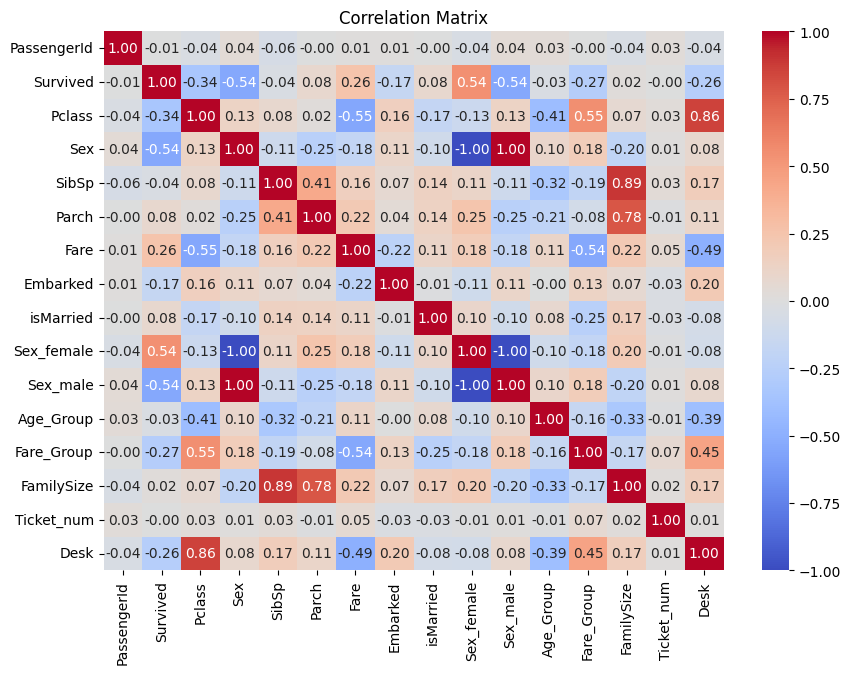

In [69]:
correlation_matrix = train_data.corr()
plot_corr(correlation_matrix)

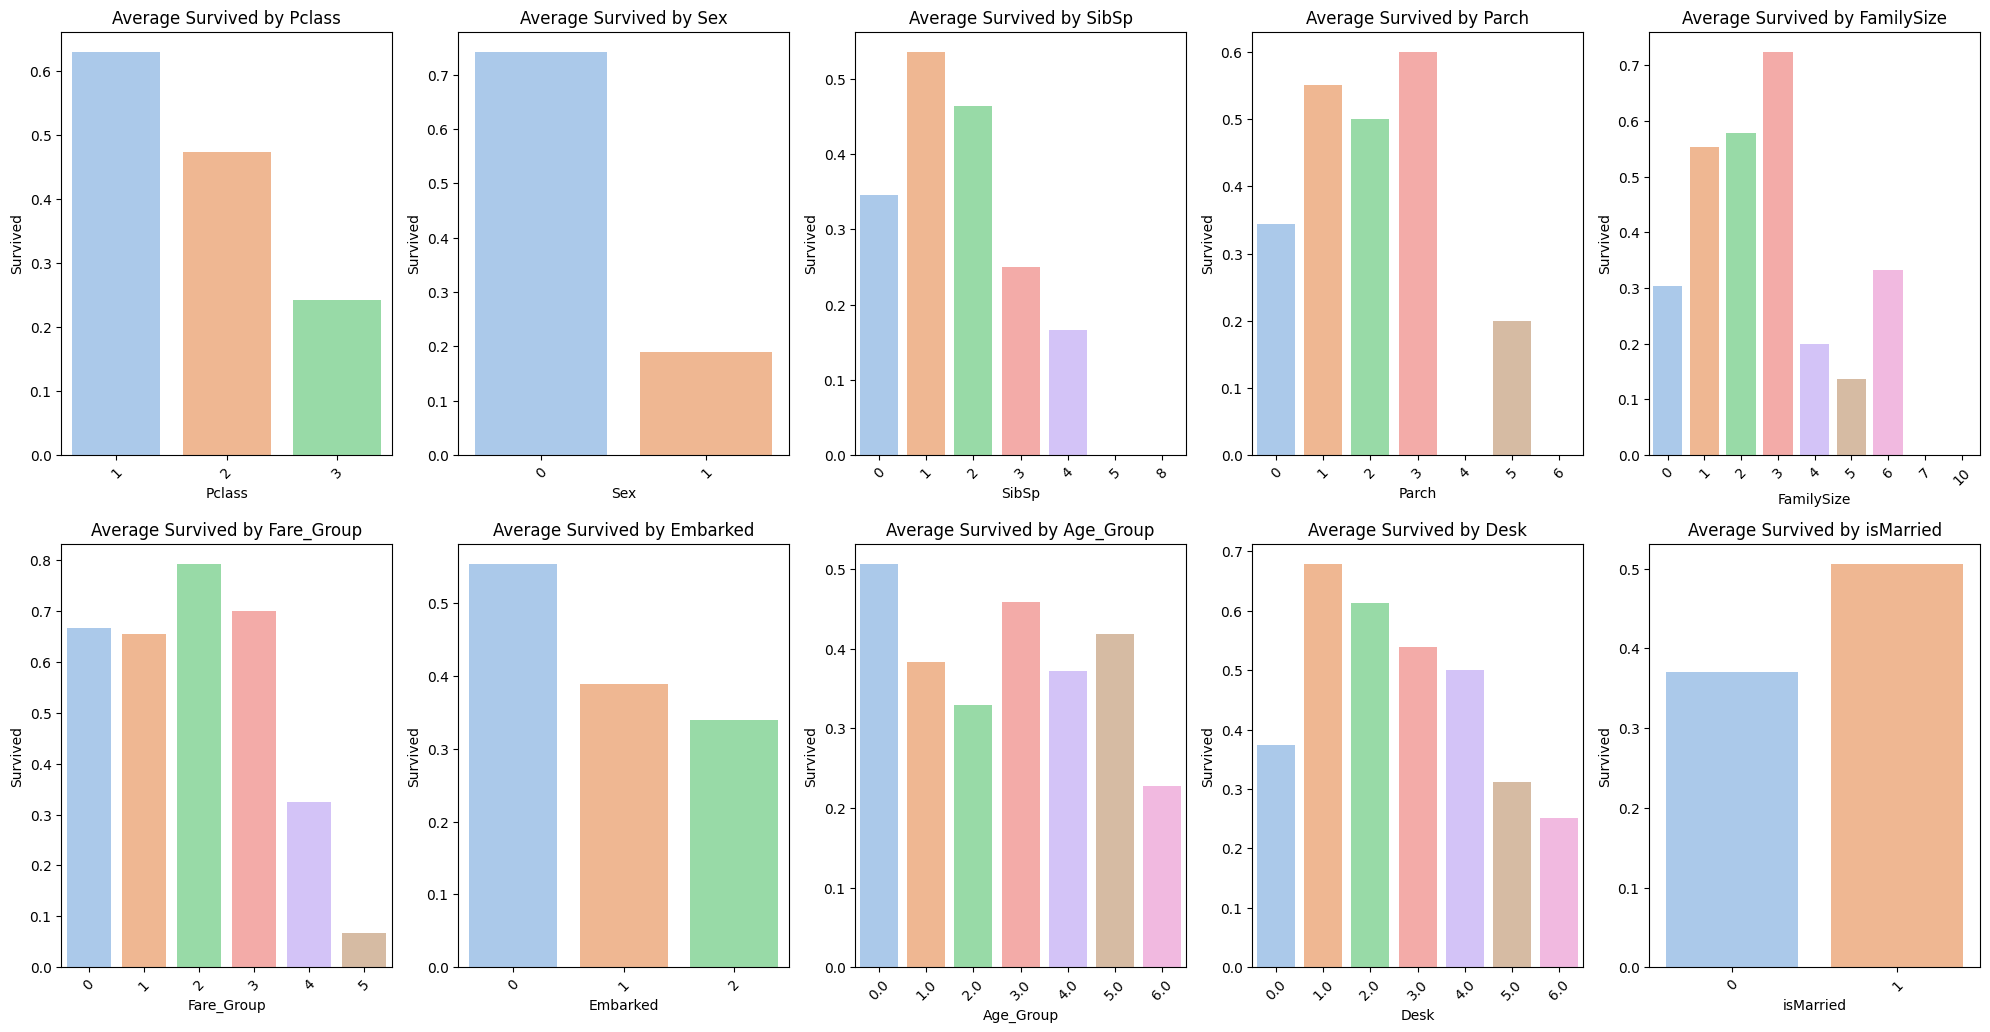

In [72]:
# Define the categorical variables
categorical_vars = ['Pclass', 'Sex', 'SibSp', 'Parch', 'FamilySize', 'Fare_Group', 'Embarked', 'Age_Group', 'Desk', 'isMarried']
plot_avg_survival(train_data, categorical_vars, 'Survived')


* Fare works better than Fare_Group
* FamilySize works the same as Parch and better than Parch and SibSp together

### Testing various feature sets:

| Features                                         | Model  | Best CV Score   | Test data sample score  | Accuracy score
|-------------                                     |------|----|---|---|
| Pclass                                           | LogisticRegression  |  6257  | 0.6924  |  |
| Pclass, Sex                                      | LogisticRegression  |  0.7821  | 0.7878  | 0.782 |
| Pclass, Sex_Female, Sex_Male                     | LogisticRegression  |  0.7821  | 0.7878  | 0.704|
| Pclass, Fare                                     | DecisionTreeClassifier | 0.7039   | 0.7149  | 0.821 | 
| Pclass, Sex, Fare                                | DecisionTreeClassifier |  0.8268   |  0.8230  | 0.821 |
| Pclass, Sex, Fare, FamilySize                    | RandomForestClassifier |  0.7989  | 0.8174  | 0.793 |
| Pclass, Sex, Fare, Age_Group                     | LogisticRegression |  0.8101 | 0.8104 | 0.804  |
| Pclass, Sex, Fare, Desk                          | RandomForestClassifier |  0.8101 | 0.8160 | 0.799 |
| Pclass, Sex, Fare,  Age_Group, Desk              | RandomForestClassifier |  0.8156 | 0.8076 | 0.816 |
| Pclass, Sex, Fare,  Age_Group, Desk, FamilySize  | RandomForestClassifier |  0.8212 | 0.8118 | 0.793 |
| Pclass, Sex, Fare,  Age_Group, FamilySize        | RandomForestClassifier |  0.8212 | 0.8145 | |
| Pclass, Sex, Fare,  Desk, FamilySize             | RandomForestClassifier |  0.8045 | 0.8089 | |
| Pclass, Sex, Fare,  Desk, Embarked               | DecisionTreeClassifier | 0.8101   | 0.8090 |0.810|
| Pclass, Sex, Fare,  Age_Group, Desk, Embarked    | RandomForestClassifier |  0.8156 | 0.8244| 0.816 |
| Pclass, Sex, Fare, Embarked                      | DecisionTreeClassifier |  0.8212   |  0.8159  | 0.821 |



In [86]:
#X_features = ['Pclass','Fare', 'Sex', 'Embarked','Desk']
X_features = ['Pclass','Sex','Fare', 'Desk', 'FamilySize', "Age_Group","Embarked", 'isMarried']

# Prepare target and features
#X = train_data.drop(['Survived', "PassengerId"], axis=1)  # Features
X = pd.DataFrame(train_data, columns=X_features) # Features
y = train_data['Survived']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
X.head(5)

,Pclass,Sex,Fare,Desk,FamilySize,Age_Group,Embarked,isMarried
0,3,1,7.2500,6.0,1,2.0,2,0
1,1,0,71.2833,2.0,1,3.0,0,0
2,3,0,7.9250,5.0,0,2.0,2,0
3,1,0,53.1000,2.0,1,3.0,2,1
4,3,1,8.0500,5.0,0,3.0,2,0


In [91]:
# Define classifieriers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier()
}

In [92]:
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 5, 10], 'penalty':['l1','l2'],'solver':['liblinear']}, 
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 1, 3, 5,9, 10, 11, 12]},  
    'Random Forest': {'n_estimators': [10, 29, 30, 31, 32, 33, 35, 36, 37], 'max_features': ['sqrt', 'log2']},  
    'SVM': {'C': [0.01, 0.05, 1], 'kernel': ['poly','sigmoid', 'rbf']}, 
    'KNN': {'n_neighbors': [2, 3, 5],  'algorithm': ['ball_tree', 'kd_tree', 'brute']},  
    'Naive Bayes': {},
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 10],
        'n_estimators': [50, 100, 200],
        'subsample': [0.5, 0.7, 1.0]
    }
}

In [93]:
score_train, score_test, best_model, best_score = evaluate_classifiers(classifiers, param_grids, X_train, y_train, X_test, y_test)

Evaluating Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best cross-validation score: 0.8089
Train score: 0.8160
Test score: 0.7877


Evaluating Decision Tree...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best cross-validation score: 0.8188
Train score: 0.8357
Test score: 0.7933


Evaluating Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best cross-validation score: 0.8174
Train score: 0.9607
Test score: 0.8045


Evaluating SVM...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best cross-validation score: 0.6840
Train score: 0.6924
Test score: 0.6257


Evaluating KNN...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best cross-validation score: 0.7809
Train score: 0.8427
Test score: 0.7151


Evaluating Naive Bayes...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best cross-validation score: 0.7527
Train score: 0.7598
Test score: 0.7598


Evaluating XGBoost...
Fit

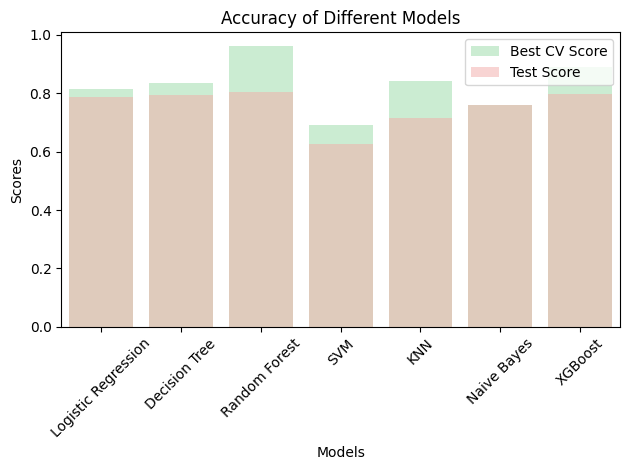

In [120]:
df = pd.DataFrame({'models': list(param_grids.keys()), 'score_train': score_train, 'score_test': score_test})
plot_models_comparision(df)

In [121]:
# Train the chosen model on the entire training dataset
#best_model.fit(X, y)

print(f"Best model is: {best_model}")
print(f"X_features is: {X_features}")


Best model is: RandomForestClassifier(max_features='log2', n_estimators=31)
X_features is: ['Pclass', 'Sex', 'Fare', 'Desk', 'FamilySize', 'Age_Group', 'Embarked', 'isMarried']


In [122]:
print(predictions)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 1 1 0 1 0 0 1]


# Model Evaluation

The best model occurs to be RandomForestClassifier. Now let us evaluate in detail this model, calculating:

1. **Best score CV (Cross-Validation):**
The highest performance metric achieved by during cross-validation.

2. **Best score on test data:**
This indicates the highest performance metric  evaluated on a separate, unseen test dataset. 

3. **Accuracy:**
It measures the proportion of correctly classified examples out of the total number of examples. Mathematically, accuracy is calculated as the number of correct predictions divided by the total number of predictions.

4. **Confusion Matrix:**
A confusion matrix is a table that visualizes the performance of a classification model by comparing actual and predicted class labels. It summarizes the number of true positives, true negatives, false positives, and false negatives. From the confusion matrix, various performance metrics such as accuracy, precision, recall, and F-score can be calculated.

5. **Precision and Recall:**
Precision measures the proportion of true positive predictions out of all positive predictions, while recall measures the proportion of true positive predictions out of all actual positives.

6. **F-Score:**
The F-score (or F1-score) is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. The F1-score reaches its best value at 1 and worst at 0.

7. **Precision-Recall Curve:**
A precision-recall curve is a graphical representation of the trade-off between precision and recall for different thresholds used in a classification model. It is useful when dealing with imbalanced datasets where one class is much more prevalent than the other.

8. **ROC AUC Curve** (Receiver Operating Characteristic Area Under the Curve):
The ROC AUC curve is a graphical plot that illustrates the diagnostic ability of a binary classification model across different thresholds. It shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity). The area under the ROC curve (AUC) provides a single scalar value representing the overall performance of the classifier, with higher values indicating better performance.

In [123]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve

# Predictions on test data
y_pred = best_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Precision
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

# F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Precision-Recall Curve
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

# ROC AUC Curve
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
print("ROC AUC:", roc_auc)

Accuracy: 0.8044692737430168
Precision: 0.8524590163934426
Recall: 0.6666666666666666
F1-score: 0.7482014388489209
ROC AUC: 0.7887788778877888


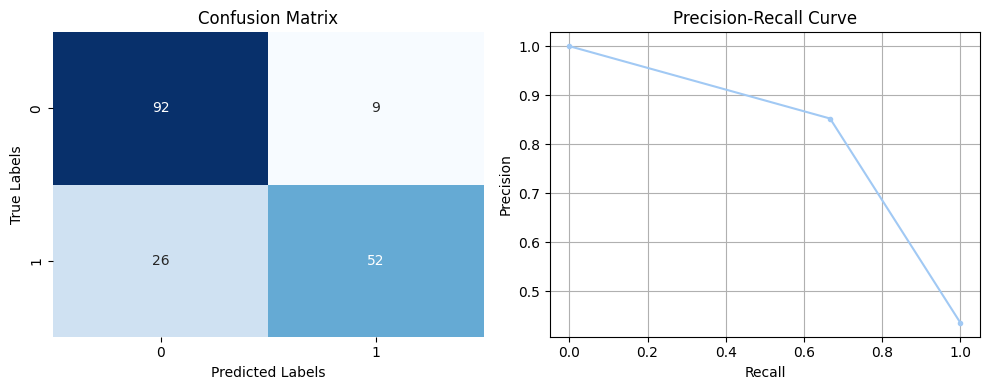

In [124]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

plt.tight_layout()
plt.show()

## CONCULSIONS

### Accuracy

Accuracy measures the overall correctness of the model's predictions. In this case, the model achieves an accuracy of approximately 80.4%, indicating that around 80.4% of the predictions made by the model are correct.
    
### Confusion Matrix

The first row is about the **not-survived-predictions**: 92 passengers were correctly classified as not survived (called true negatives) and 9 where wrongly classified as not survived (false positives).

The second row is about the **survived-predictions**: 26 passengers where wrongly classified as survived (false negatives) and 52 where correctly classified as survived (true positives).

### Precision, Recall and F-score

A precision value of 0.852 means that approximately 85.2% of the instances predicted as positive by the model are actually positive. The model correctly identified approximately 66.7% of all actual positive instances in the dataset. Since precission and recall are not perfectely balanced, F-score is 74% which is not the best, but also closer to 1. 

### ROC
In this case, the model achieves an ROC AUC of approximately 0.789, indicating reasonably good performance in class separation.

# Create an output file for submission

In [125]:
submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predictions})

In [126]:
submission_df.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [139]:
import os
from datetime import datetime

# Generate a filename with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'submission_{timestamp}.csv'

# Save the DataFrame to a CSV file
submission_df.to_csv('submission_4.csv', index=False)

In [140]:
average_survival = submission_df['Survived'].mean()
print(f"Average survival rate on test data predicted with {best_model} is {average_survival}")

Average survival rate on test data predicted with RandomForestClassifier(max_features='log2', n_estimators=31) is 0.3253588516746411
